In [92]:
import os
import sys
import time
nb_dir = os.path.split(os.getcwd())[0]

sys.path.append(nb_dir)
sys.path.append(os.path.split(nb_dir)[0])

In [93]:
import pandas as pd
from PIL import Image, ImageDraw
import copy

In [94]:
from services.xml_document_info import (get_xml_info, get_xml_image_info)
from services import get_xml
from src.services import main
from services.preprocess import prepocess_pdf_rgions
from services.get_tables import page_num_correction , get_text_table_line_df

from utilities.xml_utils import (extract_image_paths_from_pdf,
                                 extract_xml_from_digital_pdf,
                                 extract_html_bg_images_from_digital_pdf,
                                 create_directory,
                                 read_directory_files)
import config

In [95]:
def draw_box(filepath, desired_width, desired_height, df, color="green", save=False):
    image  = Image.open(filepath)
    image  = image.resize((desired_width, desired_height))
    draw   = ImageDraw.Draw(image)
    
    for index, row in df.iterrows():
        left   = int(row['text_left'])
        right  = int(row['text_width'] + left)
        top    = int(row['text_top'])
        bottom = int(row["text_height"] + top)
        
        draw.rectangle(((left, top), (right,bottom)), outline=color)
    save_filepath = os.path.join(os.path.dirname(filepath), 'processed_' + os.path.basename(filepath))
    if save:
        image.save(save_filepath)
    
    return image

def show_df(df):
    return df.head(df.shape[0])

## start of the program

In [96]:
'''
  folder structure of test data goes like this
  - notebooks
      - sample-data
          - input
          - output
          
  the pdfs are present in "input" directory and they are *.pdf is added into .gitignore
  just to save repo size.
'''

base_dir   = os.getcwd()
input_dir  = os.path.join(base_dir, 'sample-data', 'input')
save_dir = os.path.join(base_dir, 'sample-data', 'bbox_output')

output_dir = os.path.join(base_dir, 'sample-data', 'output')
create_directory(input_dir)
create_directory(output_dir)

filename   = 'Madras_HC_02.pdf'


## extract the pdf into xml & background images for downstream processing

In [97]:
pdf_filepath      = os.path.join(input_dir, filename)
working_dir       = os.path.join(output_dir, os.path.splitext(filename)[0])

ret               = create_directory(working_dir)

start_time        = time.time()

pdf_image_paths   = extract_image_paths_from_pdf(pdf_filepath, working_dir)
pdf_xml_dir       = extract_xml_from_digital_pdf(pdf_filepath, working_dir)
pdf_bg_image_dir  = extract_html_bg_images_from_digital_pdf(pdf_filepath, working_dir)

end_time          = time.time()
extraction_time   = end_time - start_time

In [98]:
xml_files      = read_directory_files(pdf_xml_dir, pattern='*.xml')
bg_files       = read_directory_files(pdf_bg_image_dir, pattern='*.png')

print("Extracted xml, background images & images of file: %s" % (filename))
print('Extraction time (%f) average extraction time (%f)' % (extraction_time, extraction_time/len(bg_files)))

Extracted xml, background images & images of file: Madras_HC_02.pdf
Extraction time (1.929235) average extraction time (0.482309)


In [99]:
xml_dfs, page_width, page_height = get_xml_info(xml_files[0])
img_dfs, page_width, page_height = get_xml_image_info(xml_files[0])


Total number of pages (4) in file (Madras_HC_02.xml)
Total number of pages (4) in file (Madras_HC_02.xml)


In [100]:
page_index      = 0

img_filepath    = pdf_image_paths[page_index]
bg_img_filepath = bg_files[page_index]
df              = xml_dfs[page_index]
img_df          = img_dfs[page_index]


# Draw Bounding box using v_df

In [101]:
def draw_vdf(xml_dfs,img_dfs,image_files,page_height,file_name,file_index):
    multiple_pages = False
    if len(xml_dfs) > 1:
        multiple_pages =True
    header_region, footer_region = prepocess_pdf_rgions(xml_dfs, page_height)
    img_df = img_dfs[file_index]
    table_image = working_dir + '/' + page_num_correction(file_index , 3) + '.png'
    #in_df, table_df, line_df = get_text_table_line_df(table_image, xml_dfs[file_index])
    in_df = xml_dfs[file_index]
    v_df = get_xml.get_vdf(in_df, image_files, config.DOCUMENT_CONFIGS, file_index,header_region , footer_region, multiple_pages)

    return v_df


In [102]:
v_df = draw_vdf(xml_dfs,img_dfs,bg_files,page_height,filename,page_index)

/home/naresh/Tarento/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/services/preprocess.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['text_right']  = sub_df['text_left'] + sub_df['text_width']
/home/naresh/Tarento/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/services/preprocess.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['text_bottom'] = sub_df['text_top'] + sub_df['text_height']
/home/naresh/Tarento/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/serv

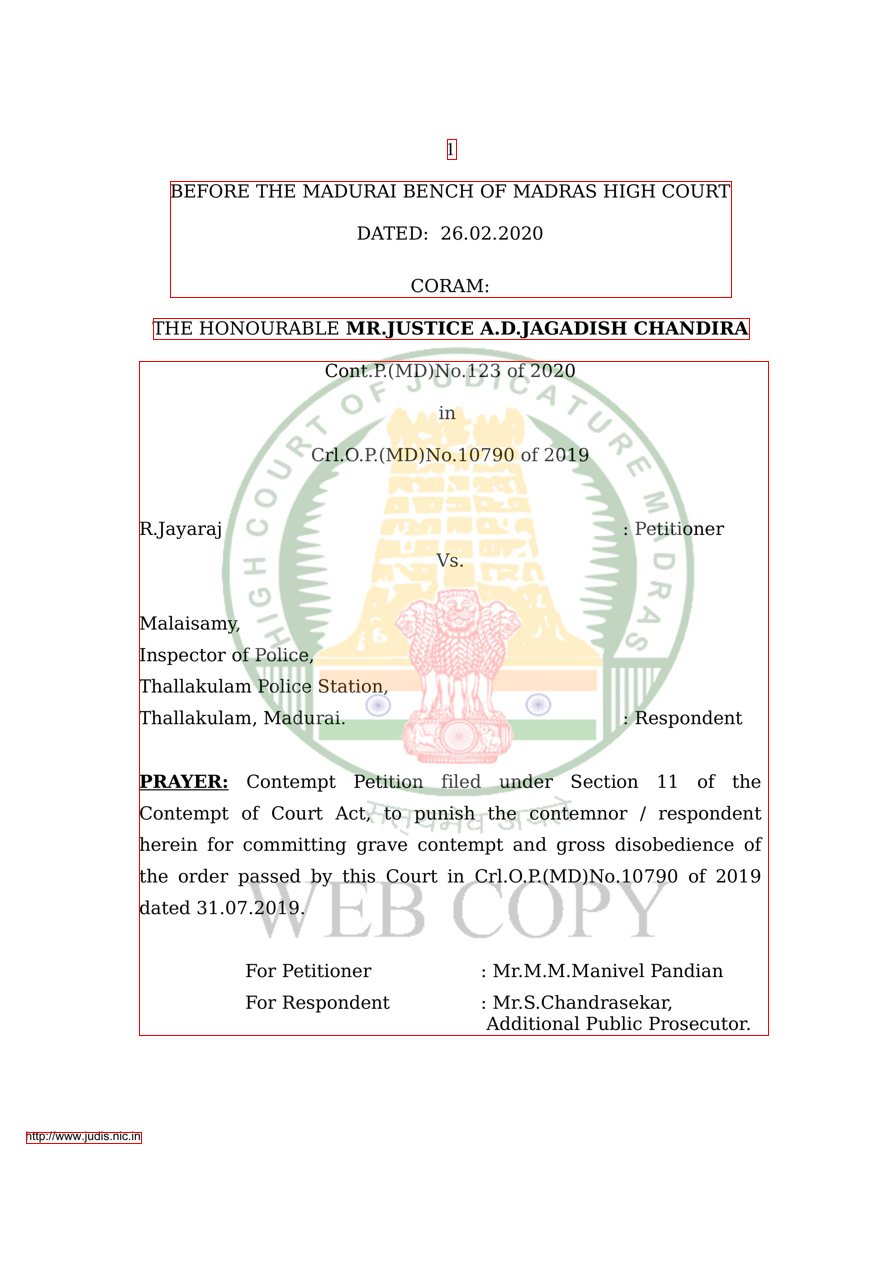

In [103]:
draw_box(img_filepath, page_width, page_height, v_df, color='red')

# Draw bounding box using p_df

In [104]:
def draw_pdf(xml_dfs,img_dfs,image_files,page_height,file_name,file_index):
    
    multiple_pages = False
    if len(xml_dfs) > 1:
        multiple_pages =True
    header_region, footer_region = prepocess_pdf_rgions(xml_dfs, page_height)
    img_df = img_dfs[file_index]
    #table_image = working_dir + '/' + page_num_correction(file_index , 3) + '.png'
    in_df = xml_dfs[file_index]
    v_df = get_xml.get_vdf(in_df, image_files, config.DOCUMENT_CONFIGS, file_index,header_region , footer_region, multiple_pages)
    p_df = main.process_page_blocks(v_df, config.DOCUMENT_CONFIGS, config.BLOCK_CONFIGS)
    p_df = p_df.reset_index(drop=True)
    return p_df


In [105]:
p_df = draw_pdf(xml_dfs,img_dfs,bg_files,page_height,filename,page_index)

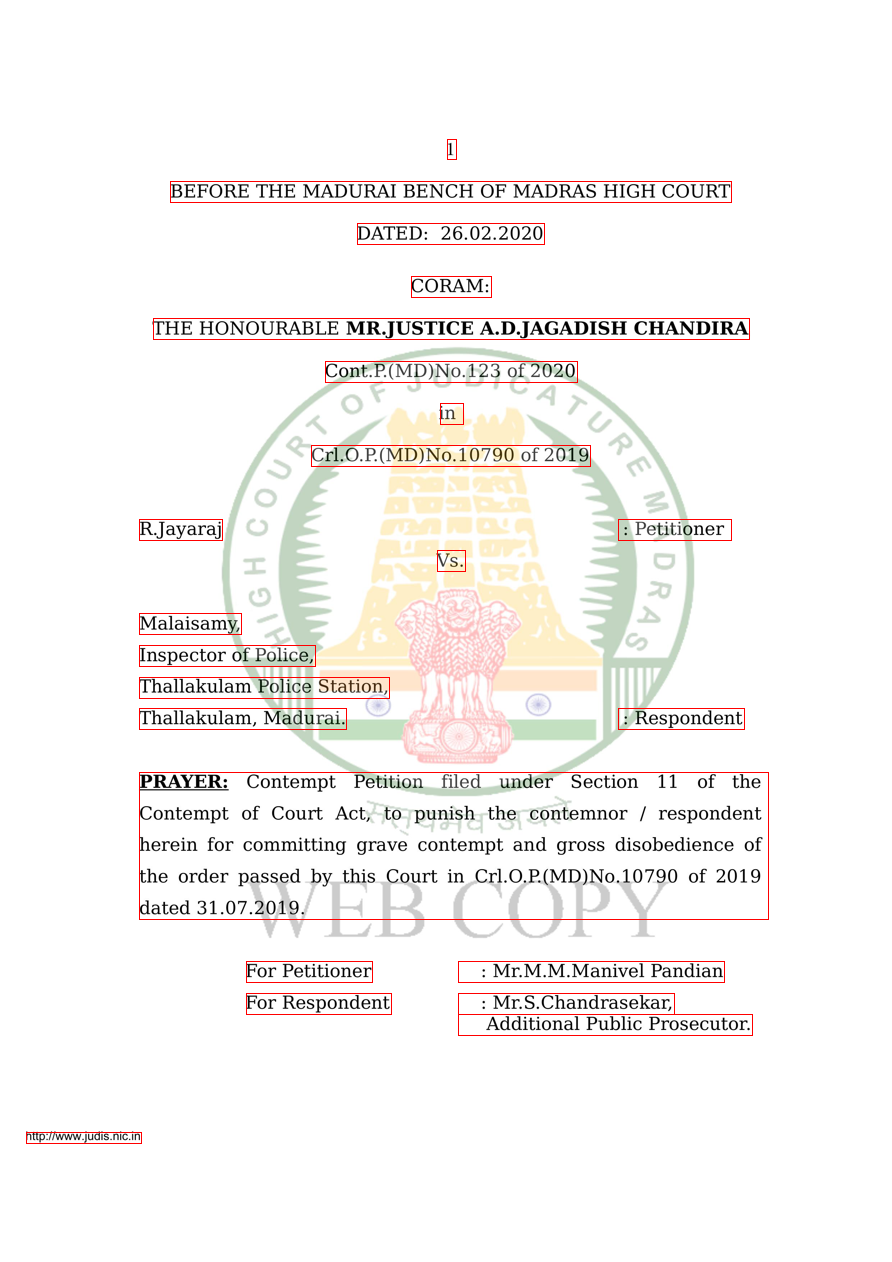

In [106]:
draw_box(img_filepath, page_width, page_height, p_df, color='red')

# Draw bounding box for json response 

In [107]:
from src.services import main

In [108]:
pdf_path = input_dir+"/"+filename
save_path  = save_dir+"/"+str(filename.split('.pdf')[0])
if not os.path.exists(save_path):
    os.system('mkdir -p {0}'.format(save_path))
data = main.DocumentStructure(pdf_path)

Total number of pages (4) in file (Madras_HC_02.xml)
Total number of pages (4) in file (Madras_HC_02.xml)


/home/naresh/Tarento/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/services/preprocess.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['text_right']  = sub_df['text_left'] + sub_df['text_width']
/home/naresh/Tarento/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/services/preprocess.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['text_bottom'] = sub_df['text_top'] + sub_df['text_height']
/home/naresh/Tarento/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/serv

In [109]:
def draw_box(data,image_files,save_path):
    for page_no in range(len(data)):
        image_path = sorted(image_files)[page_no]
        page_data = data[page_no]
        page_width = page_data['page_width']; page_height = page_data['page_height']
        image  = Image.open(image_path)
        image  = image.resize((page_width, page_height))
        draw   = ImageDraw.Draw(image)
        for block in page_data['blocks']:
            top     = block["text_top"];         left   = block["text_left"];  
            bottom  = top+block["text_height"];  right  = left+block["text_width"]
            draw.rectangle(((left, top), (right,bottom)), outline='red')
        save_filepath = os.path.join(save_path,image_path.split('images/')[1])
        image.save(save_filepath)
            

In [110]:
draw_box(data,pdf_image_paths,save_path)